# Выпускной проект: промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 

Заказчик хочет использовать разработанную модель для имитации технологического процесса. Ниже расскажем о деталях этого процесса. Их важно знать, прежде чем генерировать новые признаки.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

In [1]:
!pip install phik -q
!pip install --upgrade scikit-learn -q
!pip install matplotlib==3.5.0 -q
!pip install shap -q

In [2]:
#импорт всех необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler

# загружаем нужные модели

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error

import shap 

In [3]:
# Устанавливаем размер фигур по умолчанию
plt.rcParams['figure.figsize'] = [10, 5]  # Ширина и высота в дюймах

## Загрузка данных

In [4]:
#загрузим данные об электродах
data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
#загрузим данные о подаче сыпучих материалов (объем)
data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
#загрузим данные о подаче сыпучих материалов (время)
data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
#загрузим данные о продувке сплава газом 
data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
#загрузим данные о результатах измерения температуры
data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
#загрузим данные о проволочных материалах (объем)
data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
#загрузим данные о проволочных материалах (время)
data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')

In [5]:
#создадим список с датафреймами, чтобы было удобнее провести их первичный осмотр
list_data = [data_arc_new, data_bulk_new, data_bulk_time_new, data_gas_new, data_temp_new, data_wire_new, data_wire_time_new]
list_names_data = ['data_arc_new', 'data_bulk_new', 'data_bulk_time_new', 'data_gas_new', 'data_temp_new', 'data_wire_new', 'data_wire_time_new']

In [6]:
for i, name in zip(list_data, list_names_data):
    print(f'Вывод информации по датафрейму {name}')
    print('\n')
    print(i.info())
    print('\n')

Вывод информации по датафрейму data_arc_new


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


Вывод информации по датафрейму data_bulk_new


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float6

In [7]:
for i, name in zip(list_data, list_names_data):
    print(f'Вывод первых пяти строк по датафрейму {name}')
    print('\n')
    print(i.head())
    print('\n')

Вывод первых пяти строк по датафрейму data_arc_new


   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  


Вывод первых пяти строк по датафрейму data_bulk_new


   key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN    

In [8]:
# Приводим названия столбцов к змеиному регистру
for i in list_data:
    i.columns = i.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')

**Вывод:** 

Успешно загрузили данные в наши переменные и выполнили первичный осмотр всех датафреймов. Привели названия столбцов в змеиный регистр.

## Исследовательский анализ и предобработка данных

**Проверим весь датафрейм data_arc_new на аномалии и исследуем данные**

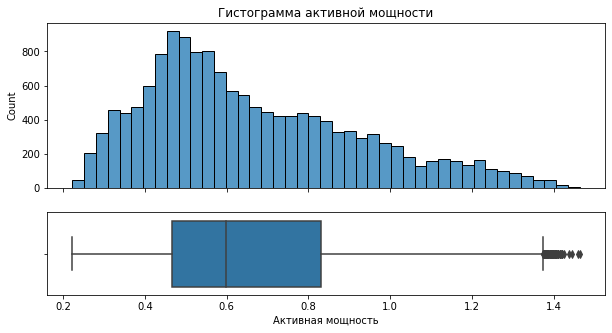

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Гистограмма
sns.histplot(data_arc_new['активная_мощность'], kde=False, ax=ax1)
ax1.set_title('Гистограмма активной мощности')

# Боксплот
sns.boxplot(x=data_arc_new['активная_мощность'], ax=ax2)
ax2.set_xlabel('Активная мощность')

plt.show()

Аномалий не обнаружено

In [10]:
#удалим явную аномалию в датафрейме, связанной с реактивной мощностью 
data_arc_new = data_arc_new.query('реактивная_мощность > -100')

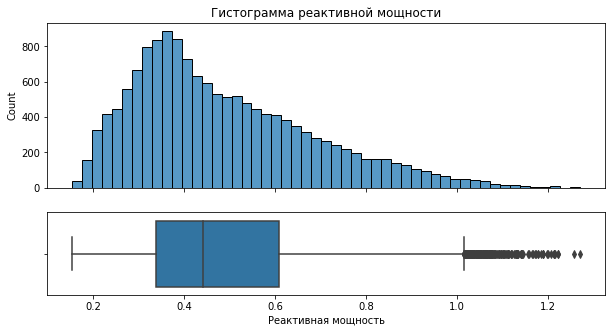

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Гистограмма
sns.histplot(data_arc_new['реактивная_мощность'], kde=False, ax=ax1)
ax1.set_title('Гистограмма реактивной мощности')

# Боксплот
sns.boxplot(x=data_arc_new['реактивная_мощность'], ax=ax2)
ax2.set_xlabel('Реактивная мощность')

plt.show()

Аномалии успешно удалены, графики выглядят адекватными.

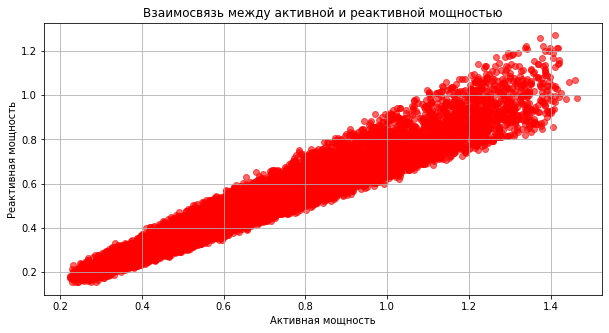

In [12]:
# График рассеяния для активной и реактивной мощности
plt.figure(figsize=(10, 5))
plt.scatter(data_arc_new['активная_мощность'], data_arc_new['реактивная_мощность'], color='red', alpha=0.6)
plt.title('Взаимосвязь между активной и реактивной мощностью')
plt.xlabel('Активная мощность')
plt.ylabel('Реактивная мощность')
plt.grid()
plt.show()

In [13]:
correlation_value = data_arc_new['активная_мощность'].corr(data_arc_new['реактивная_мощность'])
print("Корреляция между активной мощностью и реактивной мощностью:", correlation_value)

Корреляция между активной мощностью и реактивной мощностью: 0.9663734456187295


Коэффицент указывает на стабильный, предсказуемый характер нагрузки с практически постоянным коэффициентом мощности в наблюдаемом периоде.

**Проверим весь датафрейм data_gas_new на аномалии и исследуем данные**

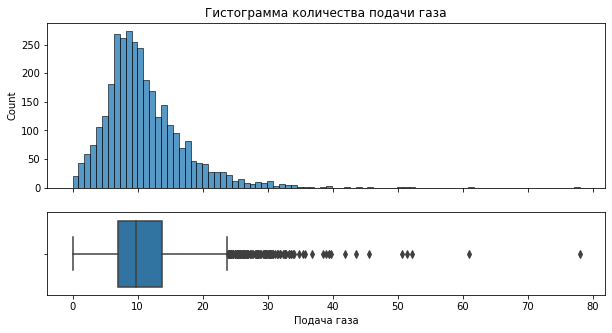

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Гистограмма
sns.histplot(data_gas_new['газ_1'], kde=False, ax=ax1)
ax1.set_title('Гистограмма количества подачи газа')

# Боксплот
sns.boxplot(x=data_gas_new['газ_1'], ax=ax2)
ax2.set_xlabel('Подача газа')

plt.show()

Аномалий не обнаружено

**Проверим весь датафрейм data_temp_new на аномалии и исследуем данные**

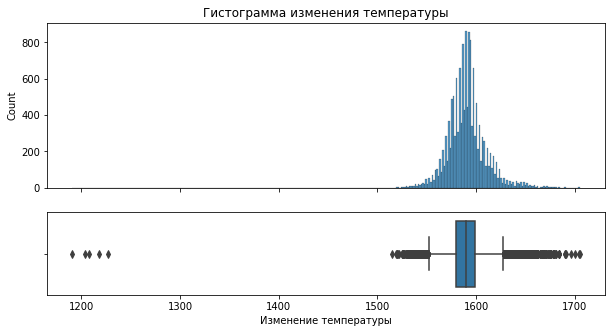

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Гистограмма
sns.histplot(data_temp_new['температура'], kde=False, ax=ax1)
ax1.set_title('Гистограмма изменения температуры')

# Боксплот
sns.boxplot(x=data_temp_new['температура'], ax=ax2)
ax2.set_xlabel('Изменение температуры')

plt.show()

In [16]:
#удалим явную аномалию в датафрейме, связанной с недостаточной температурой (для объекта моделирования)
data_temp_new = data_temp_new.query('температура > 1500')

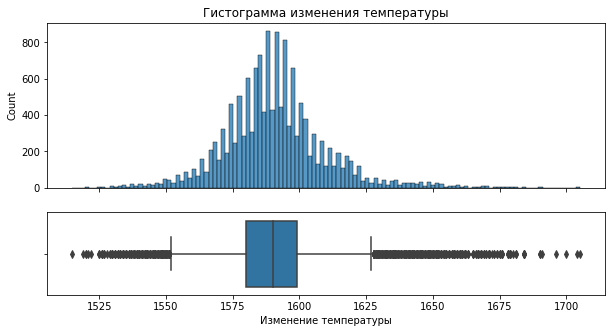

In [17]:
#повторный вывод гистограммы
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Гистограмма
sns.histplot(data_temp_new['температура'], kde=False, ax=ax1)
ax1.set_title('Гистограмма изменения температуры')

# Боксплот
sns.boxplot(x=data_temp_new['температура'], ax=ax2)
ax2.set_xlabel('Изменение температуры')

plt.show()

**Проверим везде пропущенные значения в датафреймах и обработаем их**

In [18]:
for i, name in zip(list_data, list_names_data):
    print(f'Вывод всех пропущенных значений по датафрейму {name}')
    print('\n')
    print(i.isna().sum())
    print('\n')

Вывод всех пропущенных значений по датафрейму data_arc_new


key                     0
начало_нагрева_дугой    0
конец_нагрева_дугой     0
активная_мощность       0
реактивная_мощность     0
dtype: int64


Вывод всех пропущенных значений по датафрейму data_bulk_new


key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64


Вывод всех пропущенных значений по датафрейму data_bulk_time_new


key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64


Вывод всех пропущенных значений по датафрейму data_gas_new


key      0
газ_1    0
dtype: int64


Вывод всех пропущенных зн

In [19]:
#заменим все пропущенные значения на ноль во входных признаках
data_bulk_new = data_bulk_new.fillna(0)
data_bulk_time_new = data_bulk_time_new.fillna(0)
data_wire_new = data_wire_new.fillna(0)
data_wire_time_new = data_wire_time_new.fillna(0)

In [20]:
#перезапишем список
list_data = [data_arc_new, data_bulk_new, data_bulk_time_new, data_gas_new, data_temp_new, data_wire_new, data_wire_time_new]

In [21]:
for k, name in zip(list_data, list_names_data):
    print(f'Вывод всех пропущенных значений по датафрейму {name}')
    print('\n')
    print(k.isna().sum())
    print('\n')

Вывод всех пропущенных значений по датафрейму data_arc_new


key                     0
начало_нагрева_дугой    0
конец_нагрева_дугой     0
активная_мощность       0
реактивная_мощность     0
dtype: int64


Вывод всех пропущенных значений по датафрейму data_bulk_new


key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64


Вывод всех пропущенных значений по датафрейму data_bulk_time_new


key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64


Вывод всех пропущенных значений по датафрейму data_gas_new


key      0
газ_1    0
dtype: int64


Вывод всех пропущенных значений по датафрейму data_temp_new


key             0
время_замера    0
температура     0
dtype

In [22]:
#изменим формат времени на timeseries
data_temp_new['время_замера'] = pd.to_datetime(data_temp_new['время_замера'])
data_arc_new['начало_нагрева_дугой'] = pd.to_datetime(data_arc_new['начало_нагрева_дугой'])
data_arc_new['конец_нагрева_дугой'] = pd.to_datetime(data_arc_new['конец_нагрева_дугой'])

In [23]:
data_arc_new['длительность_работы_электродов'] = data_arc_new['конец_нагрева_дугой'] - data_arc_new['начало_нагрева_дугой'] 

In [24]:
data_arc_new['длительность_работы_электродов_мин'] = data_arc_new['длительность_работы_электродов'].dt.total_seconds()/60

**Вывод**

Все пропуски успешно удалены и обработаны. Также изменили формат данных на timeseries

В ходе исследовательского анализа данных и его предобработки можно сделать вывод об имеющихся признаках. 
Скорее всего для модели нужны будут, такие признаки как:
Активная мощность
Реактивная мощность
Bulk 1 … Bulk 15 (объем)
Газ 1 (объём подаваемого газа)
Wire 1 … Wire 9 (объём подаваемых проволочных материалов)

## Объединение данных

In [25]:
data_arc_new = data_arc_new.groupby('key').agg({
    'активная_мощность': 'mean',
    'реактивная_мощность': 'mean',
    'длительность_работы_электродов_мин' : 'mean'
})
data_arc_new.columns = ['активная_мощность_среднее', 'реактивная_мощность_среднее', 'длительность_работы_электродов_мин_ср']

In [26]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 3 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   активная_мощность_среднее              3214 non-null   float64
 1   реактивная_мощность_среднее            3214 non-null   float64
 2   длительность_работы_электродов_мин_ср  3214 non-null   float64
dtypes: float64(3)
memory usage: 100.4 KB


In [27]:
data_temp_new.head()

,key,время_замера,температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [28]:
# Группируем по 'key' и оставляем только те группы, где количество строк больше 1
data_temp_new = data_temp_new.groupby('key').filter(lambda x: len(x) > 1)

In [29]:
data_temp_new = data_temp_new.groupby('key').agg(
    температура_последнее=('температура', 'last'),
    температура_первая=('температура', 'first')
)

In [30]:
data_temp_new.head()

,температура_последнее,температура_первая
key,,
1,1613.0,1571.0
2,1602.0,1581.0
3,1599.0,1596.0
4,1625.0,1601.0
5,1602.0,1576.0


In [31]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   температура_последнее  2475 non-null   float64
 1   температура_первая     2475 non-null   float64
dtypes: float64(2)
memory usage: 58.0 KB


In [32]:
merged_df = (
    data_arc_new.merge(data_bulk_new, on='key', how='inner')
    .merge(data_gas_new, on='key', how='inner')
    .merge(data_temp_new, on='key', how='inner')
    .merge(data_wire_new, on='key', how='inner')
)

In [33]:
merged_df.head()

,key,активная_мощность_среднее,реактивная_мощность_среднее,длительность_работы_электродов_мин_ср,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,температура_первая,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,0.607346,0.428564,3.660000,0.0,0.0,0.0,43.0,0.0,0.0,...,1571.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.534852,0.363339,3.379167,0.0,0.0,0.0,73.0,0.0,0.0,...,1581.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.812728,0.587491,2.183333,0.0,0.0,0.0,34.0,0.0,0.0,...,1596.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.676622,0.514248,3.087500,0.0,0.0,0.0,81.0,0.0,0.0,...,1601.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.563238,0.421998,3.620833,0.0,0.0,0.0,78.0,0.0,0.0,...,1576.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
merged_df.tail()

,key,активная_мощность_среднее,реактивная_мощность_среднее,длительность_работы_электродов_мин_ср,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,температура_первая,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
2324,2495,0.792033,0.552734,3.012500,0.0,0.0,21.0,0.0,0.0,0.0,...,1570.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2325,2496,0.695820,0.478672,2.611111,0.0,0.0,0.0,63.0,0.0,0.0,...,1554.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2326,2497,1.201746,0.817364,3.161111,0.0,0.0,0.0,85.0,0.0,0.0,...,1571.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2327,2498,0.640462,0.447964,2.500000,0.0,0.0,90.0,0.0,0.0,0.0,...,1591.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2328,2499,0.434271,0.324209,3.679167,0.0,0.0,47.0,0.0,0.0,0.0,...,1569.0,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   key                                    2329 non-null   int64  
 1   активная_мощность_среднее              2329 non-null   float64
 2   реактивная_мощность_среднее            2329 non-null   float64
 3   длительность_работы_электродов_мин_ср  2329 non-null   float64
 4   bulk_1                                 2329 non-null   float64
 5   bulk_2                                 2329 non-null   float64
 6   bulk_3                                 2329 non-null   float64
 7   bulk_4                                 2329 non-null   float64
 8   bulk_5                                 2329 non-null   float64
 9   bulk_6                                 2329 non-null   float64
 10  bulk_7                                 2329 non-null   float64
 11  bulk

In [36]:
merged_df.duplicated().sum()

0

**Вывод:**

Успешно объединили выбранные признаки по общим ключам и подготовили единую таблицу для моделирования температуры. Получилось 2329 строк, 31 столбцов с признаками.

## Исследовательский анализ и предобработка данных объединённого датафрейма

**Выведим все гистограммы объединенного датафрейма и сделаем выводы**

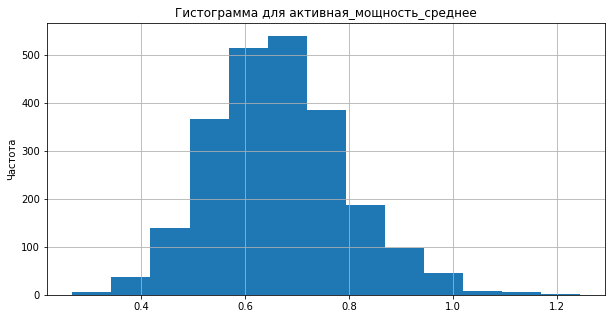

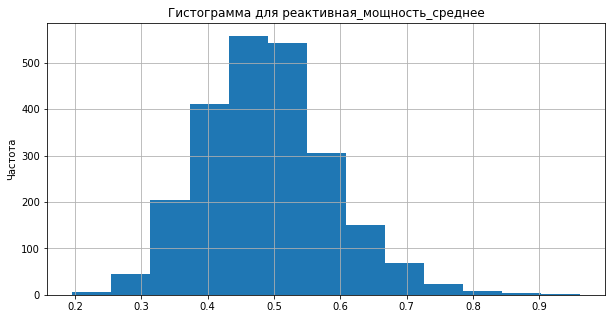

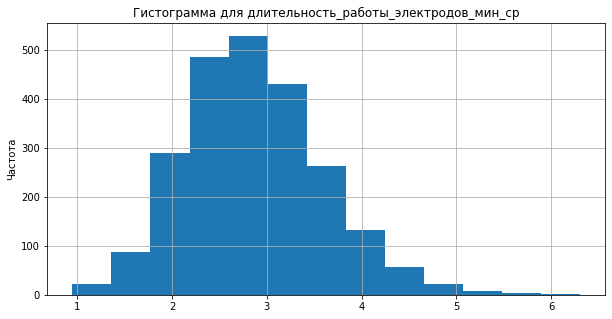

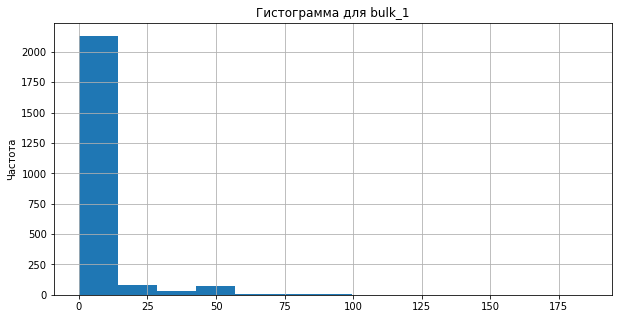

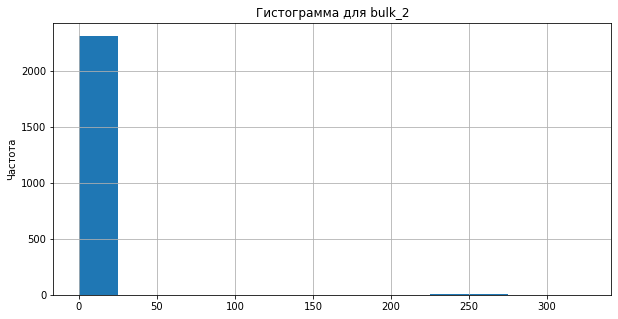

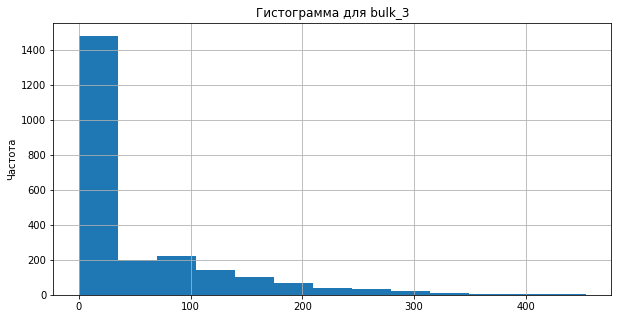

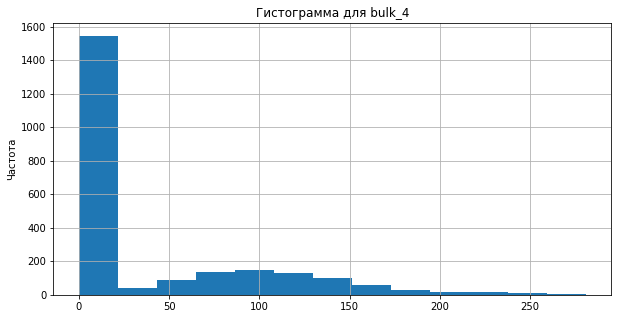

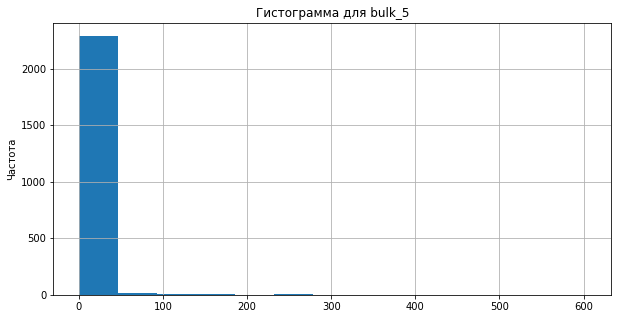

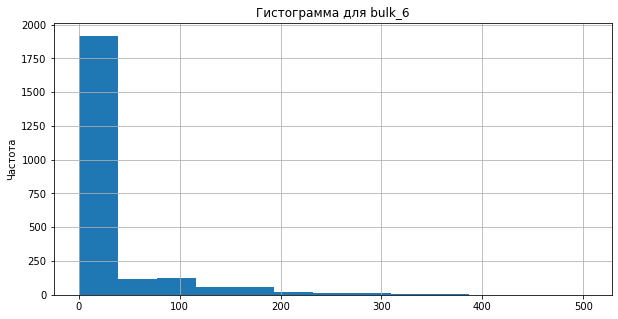

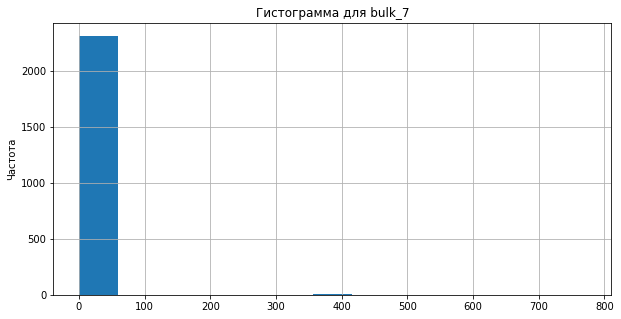

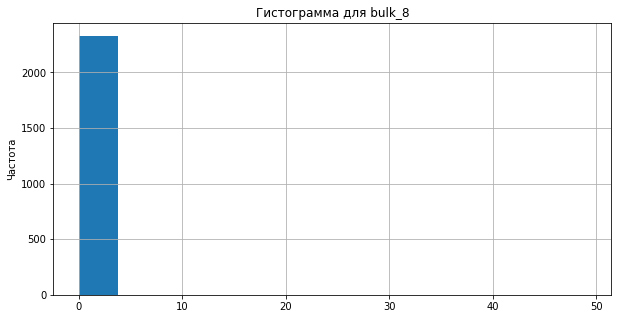

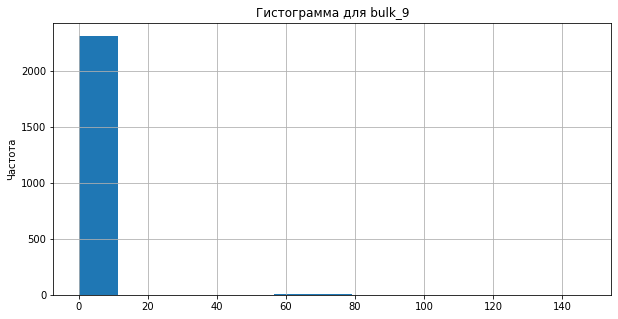

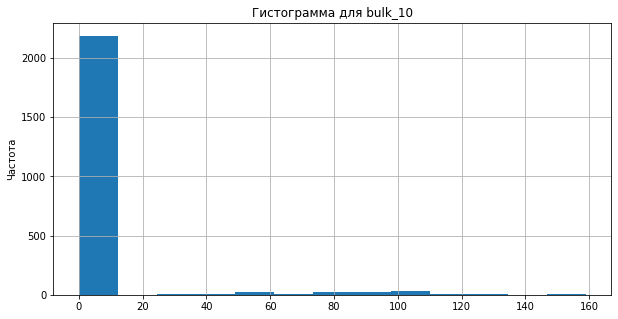

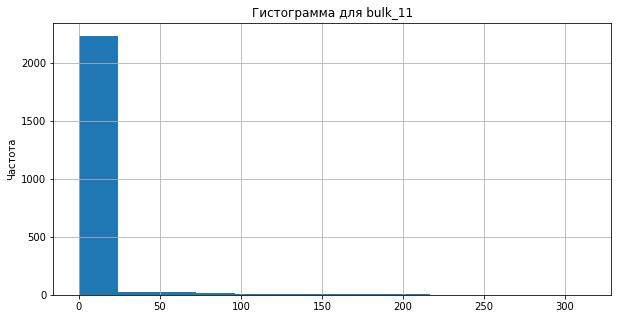

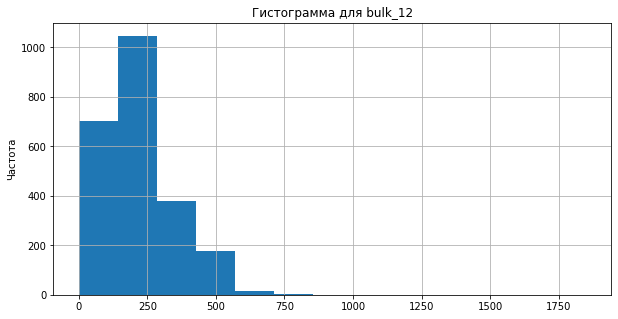

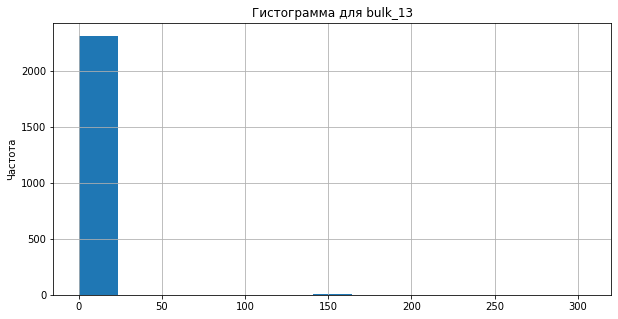

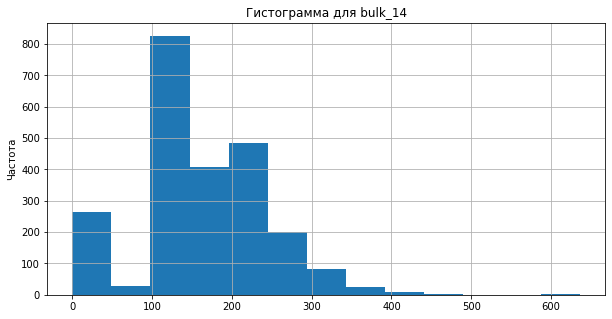

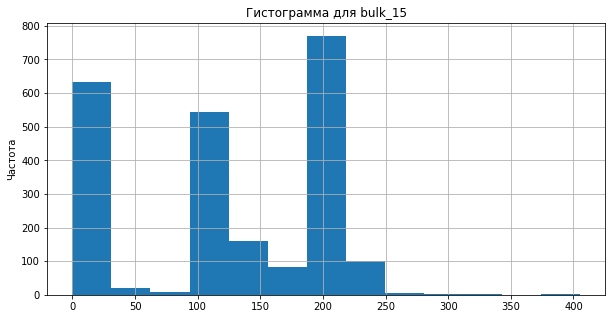

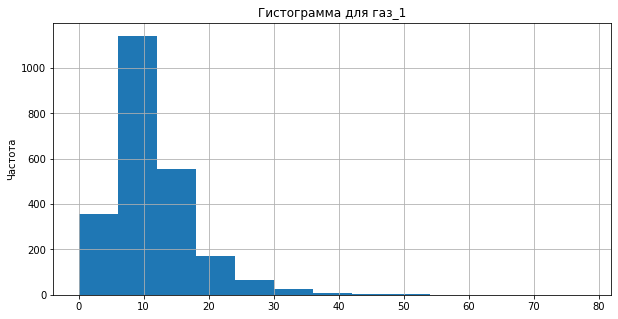

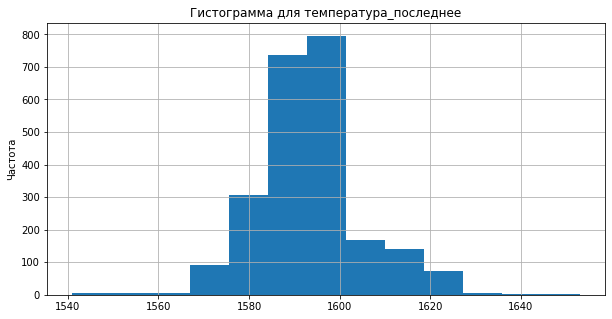

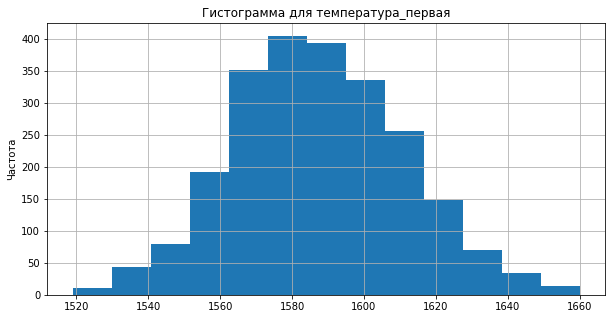

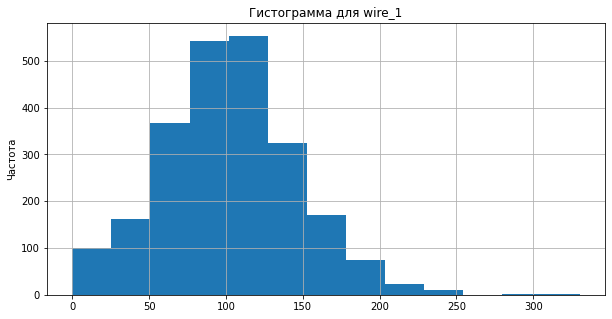

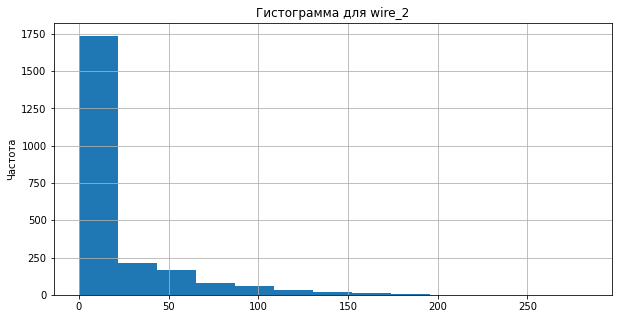

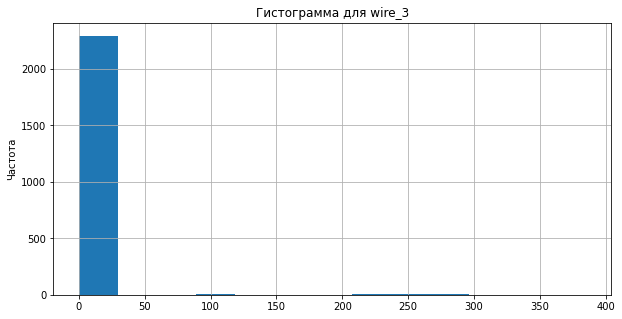

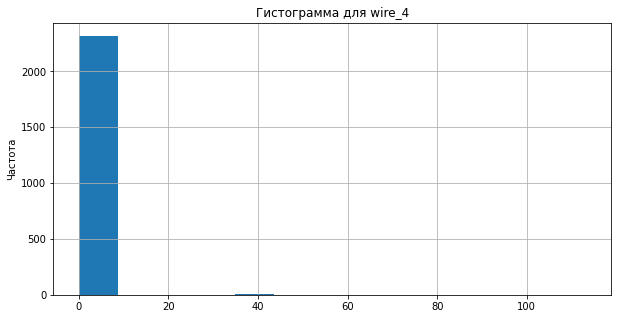

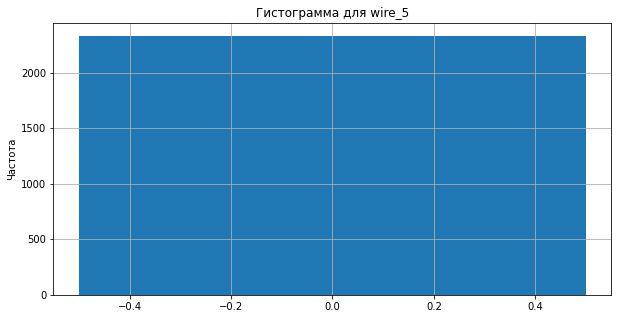

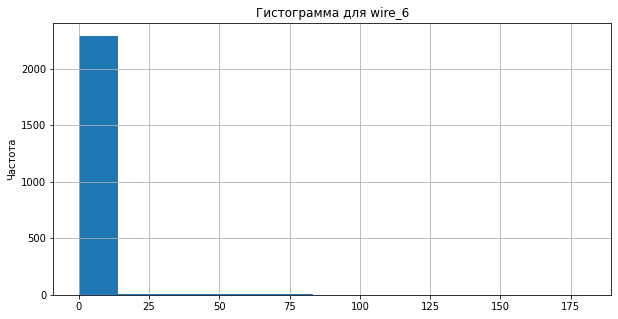

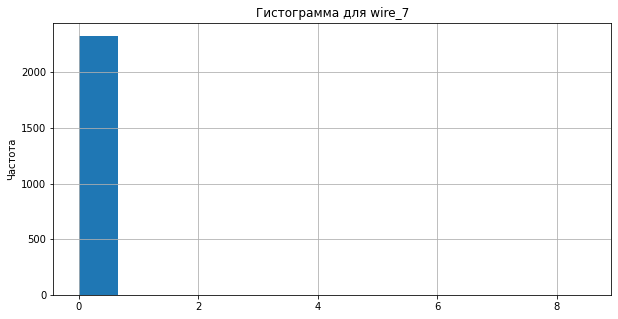

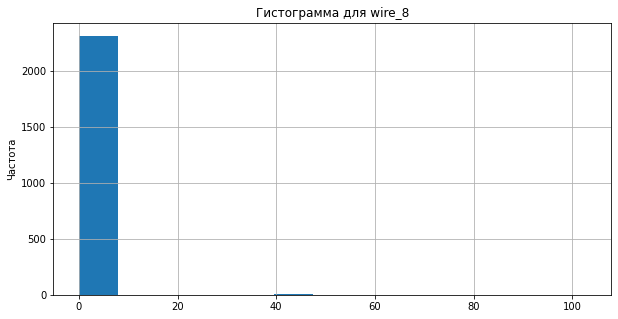

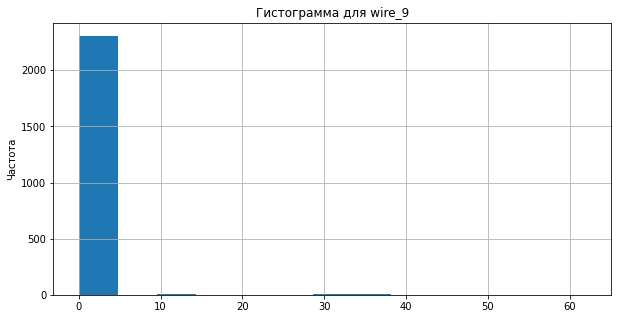

In [37]:
for column in merged_df.columns.drop('key'):
    merged_df[column].hist(bins='sturges')
    plt.title(f'Гистограмма для {column}')
    plt.ylabel('Частота')
    plt.show()

Данные адекватны. Хорошо видно, что для температуры, активной мощности, реактивной мощности, wire_1 характерны нормальные типы распределения. Температурное распределение говорит о том, что система относительно стабильна и работает в пределах своих проектных параметров. 

**Проведем корреляционный анализ объединенного датафрейма**

In [38]:
#так как мы будем обучать одну линейную модель, то необходимо проверить все входные признаки на мультиколлинеарность. (удалим цену (целевой признак) и входные признаки никак не влияющие на ценообразование машины) 
phik_overview = merged_df.drop(['key'], axis=1).phik_matrix()

interval columns not set, guessing: ['активная_мощность_среднее', 'реактивная_мощность_среднее', 'длительность_работы_электродов_мин_ср', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'газ_1', 'температура_последнее', 'температура_первая', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable wire_5 for analysis 1. Dropping this column
  warnings.warn(


In [39]:
#отфильтруем значения по корреляции свыше 0.9
phik_overview_filtered = np.where(phik_overview > 0.3, phik_overview, np.nan)

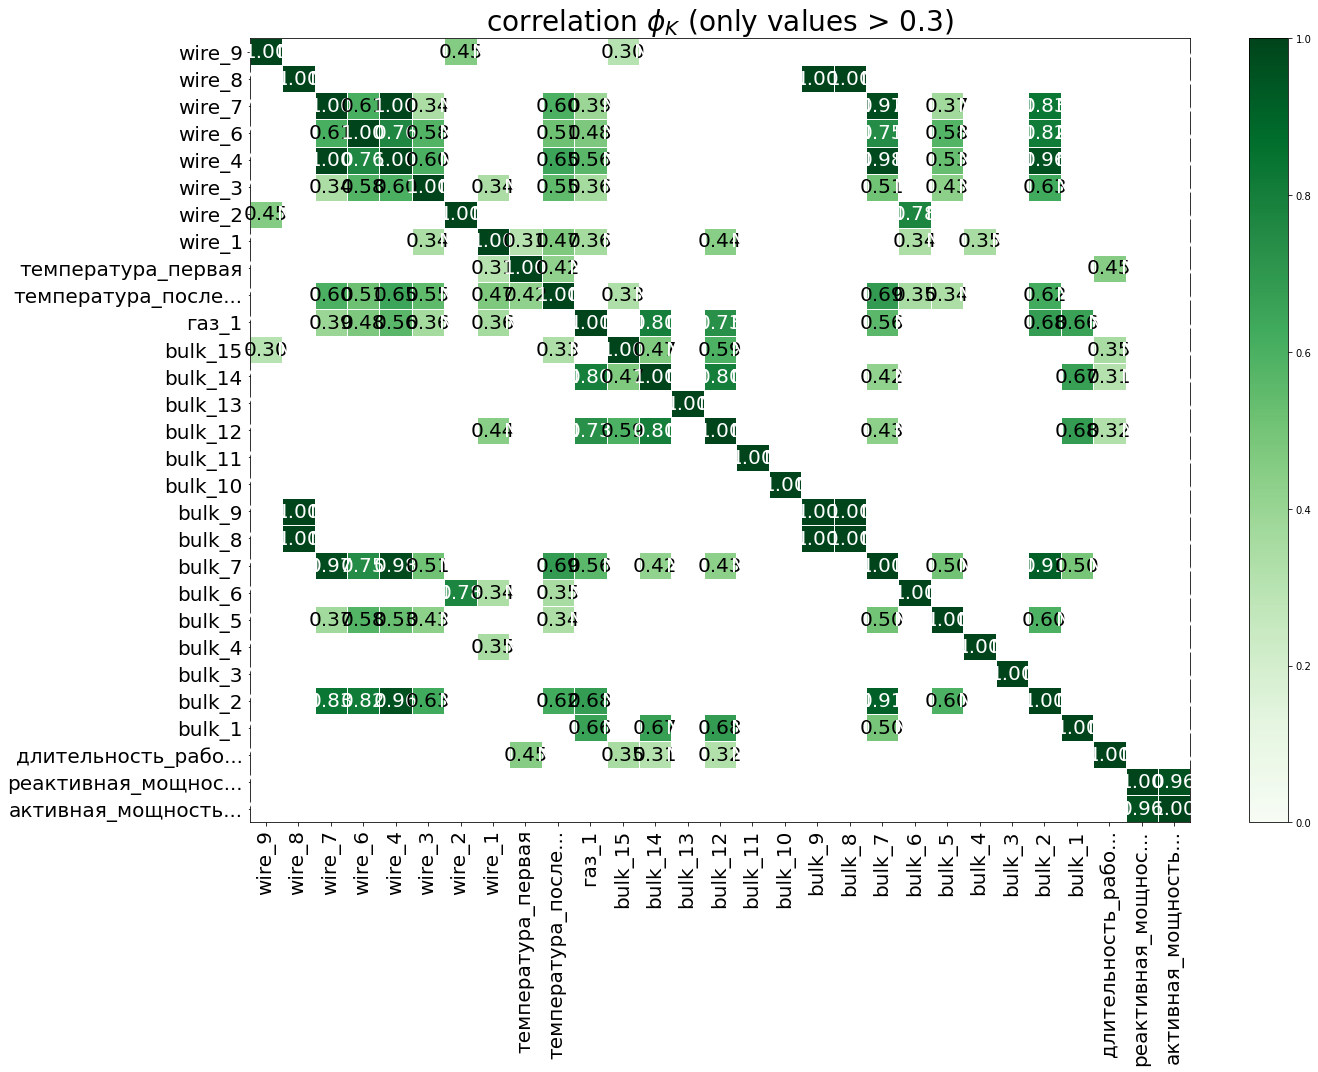

In [40]:
# Теперь визуализируем отфильтрованную матрицу
plot_correlation_matrix(
    phik_overview_filtered,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$ (only values > 0.3)',
    fontsize_factor=2,
    figsize=(20, 15)
)

Нашли сильные зависимости для Wire 8 и Bulk 8, wire 8 и bulk 9, wire 4 и Bulk 2, реактивная мощность и активная мощность. Удалим значения wire 8, bulk 2, а также удалим реактивную мощность.

In [41]:
#удалим мультиколлинеарные признаки и столбец key.
merged_df = merged_df.drop(['key', 'wire_8', 'bulk_2'], axis=1)

In [42]:
merged_df['полная_мощность'] = np.sqrt(merged_df['активная_мощность_среднее']**2 + merged_df['реактивная_мощность_среднее']**2)

In [43]:
#удалим реактивную и активную мощность
merged_df = merged_df.drop(['активная_мощность_среднее', 'реактивная_мощность_среднее'], axis=1)

In [45]:
merged_df

,длительность_работы_электродов_мин_ср,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,...,температура_первая,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_9,полная_мощность
0,3.660000,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1571.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.743328
1,3.379167,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1581.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.646593
2,2.183333,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1596.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.002833
3,3.087500,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1601.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.849864
4,3.620833,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1576.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.703789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,3.012500,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,...,1570.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.965832
2325,2.611111,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,...,1554.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.844566
2326,3.161111,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1571.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,1.453368
2327,2.500000,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,...,1591.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.781577


In [46]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   длительность_работы_электродов_мин_ср  2329 non-null   float64
 1   bulk_1                                 2329 non-null   float64
 2   bulk_3                                 2329 non-null   float64
 3   bulk_4                                 2329 non-null   float64
 4   bulk_5                                 2329 non-null   float64
 5   bulk_6                                 2329 non-null   float64
 6   bulk_7                                 2329 non-null   float64
 7   bulk_8                                 2329 non-null   float64
 8   bulk_9                                 2329 non-null   float64
 9   bulk_10                                2329 non-null   float64
 10  bulk_11                                2329 non-null   float64
 11  bulk

## Подготовка данных

In [44]:
#подготовим пайплайн
#построим модели и проверим их гиперпараметры с помощью пайплайна на тренировочной выборке

RANDOM_STATE = 21225

X = merged_df.drop(['температура_последнее', 'wire_9', 'bulk_1', 'bulk_4'], axis=1)
y = merged_df['температура_последнее']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [45]:
#выделем колонки для кодирования столбцов
num_columns = ['полная_мощность', 'температура_первая', 'bulk_3', 'bulk_5', 'bulk_6', 'длительность_работы_электродов_мин_ср', 
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15', 'газ_1', 'wire_1',
       'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7']

## Обучение моделей машинного обучения

In [46]:
params_linear_regression = {
    'preprocessor__num': [StandardScaler(), 'passthrough']
}

# Пайплайн с ColumnTransformer для числовых признаков
pipe_linear_regression = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', 'passthrough', num_columns)  # замените на ваши числовые колонки
    ], remainder='drop')),
    ('model', LinearRegression())
])

# RandomizedSearchCV
randomized_search_linear_regression = RandomizedSearchCV(
    pipe_linear_regression, 
    params_linear_regression, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    random_state=RANDOM_STATE, 
    n_jobs=-1
)

randomized_search_linear_regression.fit(X_train, y_train)

# Правильный вывод результатов
print('Лучшая модель и её параметры:', randomized_search_linear_regression.best_estimator_)
print('Метрика лучшей модели на кросс-валидации:', randomized_search_linear_regression.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшая модель и её параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['полная_мощность',
                                                   'температура_первая',
                                                   'bulk_3', 'bulk_5', 'bulk_6',
                                                   'длительность_работы_электродов_мин_ср',
                                                   'bulk_7', 'bulk_8', 'bulk_9',
                                                   'bulk_10', 'bulk_11',
                                                   'bulk_12', 'bulk_13',
                                                   'bulk_14', 'bulk_15',
                                                   'газ_1', 'wire_1', 'wire_2',
                                                   'wire_3', 'wire_4', 'wire_5',
                                                   'wire_6', 'wire_7'])])),
         

In [47]:
params_catboost = {
    'preprocessor__num': ['passthrough'],  # УБИРАЕМ StandardScaler для деревьев!
    'model__iterations': [500, 1000],     
    'model__learning_rate': [0.05, 0.1],  
    'model__depth': [6, 8],                
    'model__l2_leaf_reg': [3, 5],          
    'model__border_count': [128, 254]      
}

pipe_catboost = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', 'passthrough', num_columns) 
    ], remainder='drop')),
    ('model', CatBoostRegressor(verbose=0))
])

randomized_search_catboost = RandomizedSearchCV(
    pipe_catboost,
    params_catboost,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search_catboost.fit(X_train, y_train)

print('Лучшая модель и её параметры:', randomized_search_catboost.best_estimator_)
print('Метрика лучшей модели на кросс-валидации:', randomized_search_catboost.best_score_)

Лучшая модель и её параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['полная_мощность',
                                                   'температура_первая',
                                                   'bulk_3', 'bulk_5', 'bulk_6',
                                                   'длительность_работы_электродов_мин_ср',
                                                   'bulk_7', 'bulk_8', 'bulk_9',
                                                   'bulk_10', 'bulk_11',
                                                   'bulk_12', 'bulk_13',
                                                   'bulk_14', 'bulk_15',
                                                   'газ_1', 'wire_1', 'wire_2',
                                                   'wire_3', 'wire_4', 'wire_5',
                                                   'wire_6', 'wire_7'])])),
            

In [48]:
params_randomforest = {
    'preprocessor__num': ['passthrough'],  # стандартный масштаб не обязателен деревьям
    'model__n_estimators': [100, 200, 500],      # количество деревьев, больше даёт стабильность
    'model__max_depth': [10, 20, 30, None],      # глубина деревьев, None — без ограничения
    'model__min_samples_split': [2, 5, 10, 20],  # минимальное число экземпляров для разделения
    'model__min_samples_leaf': [1, 2, 4],        # минимальное число экземпляров в листе
    'model__max_features': ['sqrt', 'log2', 0.8], # максимальное число признаков для выбора при разделении
    'model__bootstrap': [True, False]             # использование бутстрапа
}

pipe_randomforest = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', 'passthrough', num_columns)  # список числовых колонок
    ], remainder='drop')),
    ('model', RandomForestRegressor(random_state=RANDOM_STATE))
])


randomized_search_randomforest = RandomizedSearchCV(
    pipe_randomforest,
    params_randomforest,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)


randomized_search_randomforest.fit(X_train, y_train)

print('Лучшая модель и её параметры:', randomized_search_randomforest.best_estimator_)
print('Метрика лучшей модели на кросс-валидации:', randomized_search_randomforest.best_score_)

Лучшая модель и её параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['полная_мощность',
                                                   'температура_первая',
                                                   'bulk_3', 'bulk_5', 'bulk_6',
                                                   'длительность_работы_электродов_мин_ср',
                                                   'bulk_7', 'bulk_8', 'bulk_9',
                                                   'bulk_10', 'bulk_11',
                                                   'bulk_12', 'bulk_13',
                                                   'bulk_14', 'bulk_15',
                                                   'газ_1', 'wire_1', 'wire_2',
                                                   'wire_3', 'wire_4', 'wire_5',
                                                   'wire_6', 'wire_7'])])),
            

**Вывод:** 
Успешно обучили три модели. Лучшая метрика получилась для модели CatBoost, её и будем тестировать на тестовой выборке.

## Выбор лучшей модели

Проверим качество выбранной модели на тестовой выборке

In [49]:
#переведем y_test в формат numpy
y_test = y_test.to_numpy()

In [55]:
y_pred_catboost = randomized_search_catboost.predict(X_test)
scoring_best_model_catboost = mean_absolute_error(y_test, y_pred_catboost)
print('Метрика модели catboost на тестовой выборке:', scoring_best_model_catboost)

Метрика модели catboost на тестовой выборке: 6.697871068432463


In [51]:
print(f'Гиперпараметрами лучшей модели catboost являются {randomized_search_catboost.best_params_}')

Гиперпараметрами лучшей модели catboost являются {'preprocessor__num': 'passthrough', 'model__learning_rate': 0.05, 'model__l2_leaf_reg': 5, 'model__iterations': 500, 'model__depth': 8, 'model__border_count': 254}


**Вывод:**

Успешно протестировали наши модели и сделали оценку метрикой MAE. Нужная метрика достигнута на модели CatBoostRegressor.

## Анализ важности признаков

In [52]:
# извлекаем модель и трансформер из обученной модели
pre = randomized_search_catboost.best_estimator_.named_steps['preprocessor']
model = randomized_search_catboost.best_estimator_.named_steps['model']

# трансформируем данные
X_train_processed = pre.transform(X_train)
X_test_processed  = pre.transform(X_test)

# сохраняем признаков после всех трансформаций
feature_names = pre.get_feature_names_out()
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_processed,  columns=feature_names)

# создаём объяснитель для модели
# explainer = shap.Explainer(model, X_train_df)
explainer = shap.TreeExplainer(model, X_train_df)

# получаем SHAP-значения
shap_values = explainer(X_test_df)

 99%|===================| 575/583 [00:28<00:00]        

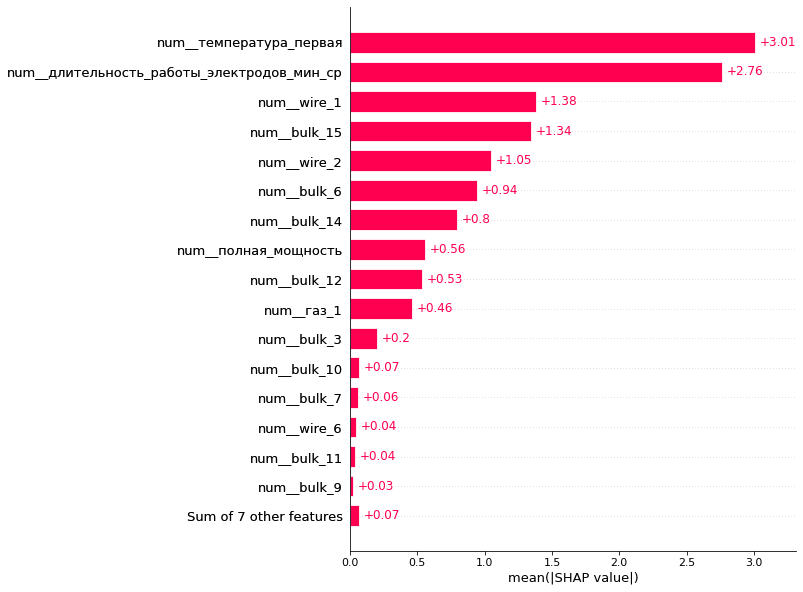

In [53]:
# графики
shap.plots.bar(shap_values, max_display=17)

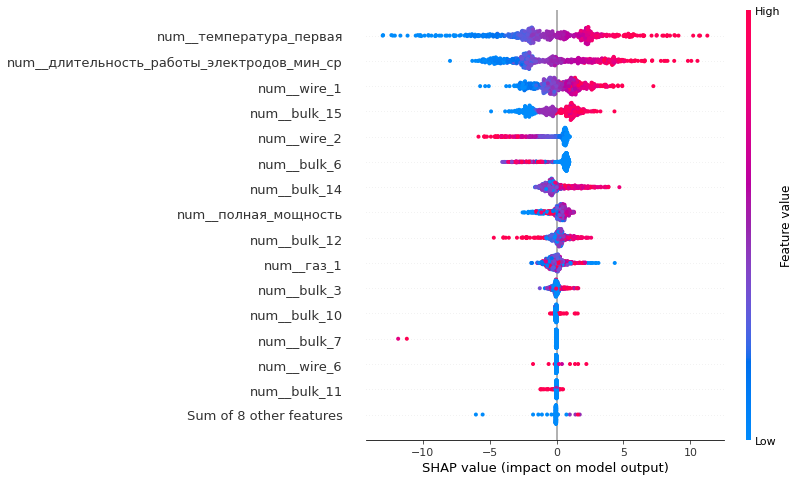

In [54]:
shap.plots.beeswarm(shap_values, max_display=16)

**Вывод**

Согласно графику SHAP мы видим, что наиболее значимым признаком для модели является первая температура, длительность работы электродов среднее, далее идут различные присадки.

## Итоговый вывод

В ходе работы над проектом успешно загрузили данные, провели предобработку и EDA. Построили три модели и проверили каждую метрикой MAE на тестовой выборке. Также провели анализ важности признаков лучшей модели. 

Самой большой трудностью оказалось объединение таблиц и понимание формата данных, а также специфика самой задачи (металлургия).
Справиться с этими трудностями помогло самостоятельное и внимательное изучение данных, а также помощь ревьюера. 

Ключевыми шагами являлись загрузка данных, обработка и исследование данных, обучение моделей, выбор лучшей модели и анализ важности признаков. 

Из списка признаков выбор пал на первую температуру, все присадки, вывод полной мощности, а также, конечно, подача газа. Вывести полную мощность удалось благодаря формуле, знакомой из физики, а первую температуру просто из данных.

Лучшей моделью оказалась модель CatBoost c RANDOM_STATE равной 21225 и гиперпараметрами {'preprocessor__num': 'passthrough', 'model__learning_rate': 0.05, 'model__l2_leaf_reg': 5, 'model__iterations': 500, 'model__depth': 8, 'model__border_count': 254}

Добавили новые признаки, такие как полная мощность и первая температура, а также длительность работы электродов. Анализ важности признаков помог сделать вывод о важности для предсказания последней температуры (самыми важными признаками оказалась первая температура, и длительность электродов, а также различные присадки (конкретно Bulk 15, wire 2). 

Для улучшения модели возможно стоит провести более тщательный поиск гиперпараметров, добавление или изменение существующих признаков.